# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_095  Q9P2E7;Q9P2E7-2        14.020
Sample_195  Q9Y4L1                 17.689
Sample_019  Q9BQT9;Q9BQT9-2        18.135
Sample_099  Q14118                 21.712
Sample_175  H7C0V4;H7C215;Q9BZR6   18.141
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_057  O60568           14.817
Sample_001  O95479;R4GMU1    17.189
Sample_101  Q13332-5         15.276
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.904
            A0A075B6Q5                 11.744
            A0A075B6R2                 12.573
            A0A075B6S5                 13.339
            A0A087WSY4                 12.413
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.916
            Q9UI40;Q9UI40-2            13.601
            Q9UIW2                     12.449
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.872
            Q9UP79                     12.748
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.138,15.050,16.842,19.863,15.929,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.694,19.067,...,15.528,15.576,14.023,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.822,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.273,17.705,17.039,15.999,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.832,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.476,15.345,17.084,18.708,14.249,19.433,11.740,11.197
Sample_207,15.739,16.877,15.469,16.898,15.096,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.948,13.342,12.668,12.977,12.666,12.407,12.719,13.139,12.709,11.930
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.625,19.067,16.127,...,11.926,14.506,12.282,13.856,12.541,13.447,11.674,12.953,12.081,13.902
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.843,12.516,11.576,10.848,12.529,14.087,12.635,13.440,13.332,11.938
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.346,13.671,13.396,13.412,12.865,12.438,11.933,12.117,13.158,15.081
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.934,13.601,13.540,13.008,13.247,12.258,12.391,13.645,11.841,15.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.746,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 320.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.19it/s]

100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.18it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.53it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.98it/s]

100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

100%|██████████| 5/5 [00:00<00:00,  5.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.63it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.70it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.21it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

100%|██████████| 6/6 [00:01<00:00,  4.12it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.96it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.08it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.50it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.52it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.49it/s]

100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.42it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.94it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.21it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.74it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.36it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.30it/s]

100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.02it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.80it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.65it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.24it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.96it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.04it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.06it/s]

100%|██████████| 9/9 [00:02<00:00,  4.19it/s]

100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.52it/s]

 30%|███       | 3/10 [00:00<00:01,  4.92it/s]

 40%|████      | 4/10 [00:00<00:01,  4.25it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.84it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.07it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.07it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.65it/s]

100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.98it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.17it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.36it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.94it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.14it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.92it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.86it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.95it/s]

100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.68it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.68it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.10it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.72it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.89it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.99it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.08it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.99it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.20it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.36it/s]

100%|██████████| 12/12 [00:02<00:00,  4.49it/s]

100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.94it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.74it/s]

 31%|███       | 4/13 [00:00<00:02,  4.17it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.85it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.05it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.27it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.18it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.23it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.26it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.34it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.39it/s]

100%|██████████| 13/13 [00:03<00:00,  4.20it/s]

100%|██████████| 13/13 [00:03<00:00,  4.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.29it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.76it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.24it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.06it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.04it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.16it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.18it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.23it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.09it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.16it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.20it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.21it/s]

100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.58it/s]

 20%|██        | 3/15 [00:00<00:03,  3.90it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.57it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.53it/s]

 40%|████      | 6/15 [00:01<00:02,  3.56it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.60it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.75it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.69it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.92it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.13it/s]

 80%|████████  | 12/15 [00:03<00:00,  4.34it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.39it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.43it/s]

100%|██████████| 15/15 [00:03<00:00,  4.44it/s]

100%|██████████| 15/15 [00:03<00:00,  4.02it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.050 0.019          0.768 0.353       0.123   
2             0.006 0.006      0.063 0.025          0.755 0.073       0.717   
3             0.004 0.003      0.042 0.015          0.753 0.073       0.712   
4             0.006 0.004      0.057 0.022          0.756 0.071       0.717   
5             0.005 0.004      0.065 0.028          0.785 0.082       0.757   
6             0.004 0.004      0.046 0.016          0.791 0.090       0.765   
7             0.005 0.004      0.063 0.025          0.785 0.087       0.765   
8             0.007 0.006      0.066 0.023          0.771 0.092       0.758   
9             0.004 0.003      0.045 0.016          0.813 0.083       0.812   
10            0.005 0.004      0.047 0.015          0.824 0.082       0.813   
11            0.005 0.003      0.050 0.020          0.823 0.082       0.816   
12            0.005 0.003      0.051 0.023          0.813 0.088       0.793   
13            0.007 0.007      0.053 0.025          0.810 0.089       0.794   
14            0.006 0.006      0.053 0.018          0.799 0.088       0.783   
15            0.005 0.004      0.050 0.018          0.817 0.091       0.781   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.205 0.133                  0.554 0.043        0.855   
2          0.121   0.730 0.080                  0.773 0.061        0.864   
3          0.109   0.726 0.072                  0.770 0.055        0.860   
4          0.104   0.731 0.068                  0.773 0.054        0.857   
5          0.110   0.765 0.073                  0.801 0.058        0.867   
6          0.103   0.772 0.075                  0.806 0.062        0.895   
7          0.101   0.769 0.070                  0.804 0.058        0.893   
8          0.111   0.759 0.081                  0.795 0.067        0.893   
9          0.087   0.809 0.067                  0.836 0.058        0.905   
10         0.090   0.815 0.068                  0.842 0.057        0.904   
11         0.095   0.816 0.071                  0.843 0.061        0.904   
12         0.097   0.798 0.071                  0.828 0.061        0.901   
13         0.096   0.798 0.072                  0.827 0.062        0.898   
14         0.093   0.787 0.072                  0.818 0.061        0.897   
15         0.102   0.793 0.072                  0.824 0.061        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.049                  0.837 0.058        210.000 0.000  
3          0.048                  0.832 0.058        210.000 0.000  
4          0.048                  0.828 0.057        210.000 0.000  
5          0.052                  0.836 0.069        210.000 0.000  
6          0.047                  0.874 0.056        210.000 0.000  
7          0.049                  0.872 0.058        210.000 0.000  
8          0.051                  0.875 0.056        210.000 0.000  
9          0.051                  0.892 0.054        210.000 0.000  
10         0.051                  0.892 0.055        210.000 0.000  
11         0.052                  0.892 0.055        210.000 0.000  
12         0.052                  0.888 0.056        210.000 0.000  
13         0.052                  0.884 0.057        210.000 0.000  
14         0.052                  0.882 0.056        210.000 0.000  
15         0.052                  0.892 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 468.64it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]

100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.59it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.48it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.73it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.67it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.36it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.33it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.71it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.98it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.89it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.34it/s]

100%|██████████| 7/7 [00:01<00:00,  3.03it/s]

100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.39it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.15it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.11it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.98it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.91it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.43it/s]

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.80it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.57it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.93it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.31it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.17it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.92it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.87it/s]

100%|██████████| 9/9 [00:02<00:00,  2.57it/s]

100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.25it/s]

 30%|███       | 3/10 [00:00<00:01,  3.56it/s]

 40%|████      | 4/10 [00:01<00:01,  3.01it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.93it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.04it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.28it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.31it/s]

100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.52it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.26it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.60it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.30it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.02it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.43it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.03it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.78it/s]

 91%|█████████ | 10/11 [00:02<00:00,  2.68it/s]

100%|██████████| 11/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.75it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.62it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.72it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.61it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.59it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.50it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.55it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.54it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.64it/s]

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.72it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.64it/s]

 31%|███       | 4/13 [00:00<00:02,  4.29it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.32it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.06it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.84it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.77it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.93it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.96it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.10it/s]

100%|██████████| 13/13 [00:04<00:00,  2.93it/s]

100%|██████████| 13/13 [00:04<00:00,  3.16it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.71it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.37it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.19it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.40it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.56it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.39it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.42it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.45it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.42it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.41it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.49it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.61it/s]

100%|██████████| 14/14 [00:04<00:00,  3.57it/s]

100%|██████████| 14/14 [00:04<00:00,  3.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.37it/s]

 20%|██        | 3/15 [00:00<00:02,  4.17it/s]

 27%|██▋       | 4/15 [00:01<00:02,  3.71it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.75it/s]

 40%|████      | 6/15 [00:01<00:02,  3.88it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.72it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.66it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.46it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.57it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.63it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.16it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.94it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.88it/s]

100%|██████████| 15/15 [00:04<00:00,  2.64it/s]

100%|██████████| 15/15 [00:04<00:00,  3.30it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.054 0.021          0.000 0.000       0.000   
2             0.005 0.004      0.052 0.020          0.676 0.116       0.453   
3             0.006 0.005      0.063 0.027          0.742 0.089       0.702   
4             0.006 0.005      0.059 0.026          0.744 0.086       0.725   
5             0.004 0.003      0.044 0.014          0.777 0.092       0.725   
6             0.005 0.004      0.043 0.015          0.781 0.095       0.743   
7             0.004 0.003      0.045 0.019          0.774 0.088       0.765   
8             0.005 0.004      0.043 0.015          0.809 0.085       0.755   
9             0.007 0.006      0.064 0.028          0.782 0.091       0.742   
10            0.005 0.004      0.059 0.023          0.837 0.082       0.797   
11            0.005 0.004      0.053 0.021          0.847 0.078       0.823   
12            0.008 0.007      0.067 0.026          0.840 0.086       0.821   
13            0.005 0.005      0.050 0.017          0.850 0.081       0.851   
14            0.006 0.005      0.067 0.029          0.847 0.081       0.849   
15            0.004 0.002      0.046 0.016          0.848 0.077       0.844   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.860   
2          0.120   0.533 0.102                  0.645 0.059        0.698   
3          0.115   0.717 0.088                  0.761 0.069        0.854   
4          0.108   0.729 0.082                  0.770 0.065        0.854   
5          0.100   0.746 0.077                  0.785 0.062        0.867   
6          0.103   0.756 0.073                  0.793 0.059        0.876   
7          0.107   0.765 0.073                  0.799 0.061        0.874   
8          0.115   0.774 0.073                  0.810 0.059        0.905   
9          0.115   0.756 0.081                  0.794 0.064        0.905   
10         0.101   0.812 0.073                  0.840 0.059        0.916   
11         0.103   0.831 0.071                  0.856 0.059        0.920   
12         0.109   0.825 0.075                  0.852 0.062        0.925   
13         0.100   0.847 0.071                  0.869 0.060        0.930   
14         0.102   0.844 0.072                  0.867 0.061        0.930   
15         0.101   0.842 0.070                  0.865 0.059        0.929   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.087        210.000 0.000  
2          0.082                  0.663 0.085        210.000 0.000  
3          0.057                  0.820 0.071        210.000 0.000  
4          0.057                  0.824 0.071        210.000 0.000  
5          0.057                  0.846 0.070        210.000 0.000  
6          0.057                  0.848 0.071        210.000 0.000  
7          0.058                  0.844 0.074        210.000 0.000  
8          0.047                  0.876 0.063        210.000 0.000  
9          0.048                  0.876 0.065        210.000 0.000  
10         0.046                  0.890 0.058        210.000 0.000  
11         0.046                  0.895 0.058        210.000 0.000  
12         0.044                  0.905 0.054        210.000 0.000  
13         0.042                  0.911 0.051        210.000 0.000  
14         0.042                  0.910 0.051        210.000 0.000  
15         0.042                  0.910 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1204.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 38.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 25.52it/s]

100%|██████████| 3/3 [00:00<00:00, 25.08it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.14it/s]

100%|██████████| 4/4 [00:00<00:00, 16.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.82it/s]

100%|██████████| 5/5 [00:00<00:00, 18.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.35it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 16.30it/s]

100%|██████████| 6/6 [00:00<00:00, 16.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.03it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.76it/s]

100%|██████████| 7/7 [00:00<00:00, 15.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.88it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.54it/s]

100%|██████████| 8/8 [00:00<00:00, 12.53it/s]

100%|██████████| 8/8 [00:00<00:00, 13.51it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.91it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.74it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.34it/s]

100%|██████████| 9/9 [00:00<00:00, 12.82it/s]

100%|██████████| 9/9 [00:00<00:00, 13.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.82it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.84it/s]

 80%|████████  | 8/10 [00:00<00:00, 18.14it/s]

100%|██████████| 10/10 [00:00<00:00, 15.98it/s]

100%|██████████| 10/10 [00:00<00:00, 17.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.99it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.04it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.11it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.58it/s]

100%|██████████| 11/11 [00:00<00:00, 14.30it/s]

100%|██████████| 11/11 [00:00<00:00, 14.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.78it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.28it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.67it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.29it/s]

100%|██████████| 12/12 [00:00<00:00, 15.20it/s]

100%|██████████| 12/12 [00:00<00:00, 15.87it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 27.15it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.03it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 19.92it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 20.27it/s]

100%|██████████| 13/13 [00:00<00:00, 20.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 25.43it/s]

 43%|████▎     | 6/14 [00:00<00:00, 18.26it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.50it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.66it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.34it/s]

100%|██████████| 14/14 [00:00<00:00, 15.89it/s]

100%|██████████| 14/14 [00:00<00:00, 16.44it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.07it/s]

 40%|████      | 6/15 [00:00<00:00, 15.46it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.89it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.99it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.45it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.67it/s]

100%|██████████| 15/15 [00:01<00:00, 13.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.047 0.021          0.000 0.000       0.000   
2             0.004 0.002      0.046 0.020          0.696 0.149       0.357   
3             0.004 0.003      0.046 0.022          0.663 0.167       0.338   
4             0.004 0.003      0.039 0.012          0.644 0.154       0.378   
5             0.003 0.000      0.035 0.003          0.623 0.152       0.378   
6             0.004 0.003      0.045 0.018          0.635 0.083       0.566   
7             0.004 0.002      0.037 0.007          0.629 0.081       0.557   
8             0.005 0.003      0.048 0.019          0.619 0.085       0.559   
9             0.004 0.003      0.039 0.009          0.617 0.074       0.563   
10            0.005 0.003      0.048 0.017          0.616 0.072       0.556   
11            0.004 0.003      0.042 0.015          0.612 0.084       0.540   
12            0.005 0.005      0.042 0.015          0.642 0.092       0.596   
13            0.006 0.005      0.050 0.020          0.633 0.092       0.585   
14            0.006 0.005      0.051 0.020          0.635 0.077       0.611   
15            0.006 0.004      0.061 0.033          0.622 0.084       0.585   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.119   0.452 0.098                  0.611 0.047        0.652   
3          0.110   0.427 0.095                  0.592 0.055        0.638   
4          0.092   0.462 0.078                  0.600 0.056        0.627   
5          0.090   0.458 0.077                  0.595 0.054        0.613   
6          0.088   0.594 0.068                  0.662 0.055        0.748   
7          0.094   0.586 0.072                  0.657 0.055        0.745   
8          0.094   0.582 0.071                  0.652 0.057        0.743   
9          0.100   0.583 0.069                  0.652 0.053        0.741   
10         0.101   0.579 0.070                  0.650 0.054        0.737   
11         0.105   0.568 0.076                  0.643 0.058        0.735   
12         0.110   0.613 0.086                  0.674 0.070        0.766   
13         0.111   0.603 0.087                  0.667 0.071        0.762   
14         0.108   0.618 0.077                  0.676 0.061        0.765   
15         0.115   0.598 0.089                  0.663 0.070        0.762   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.690 0.085        210.000 0.000  
2          0.077                  0.633 0.082        210.000 0.000  
3          0.078                  0.619 0.082        210.000 0.000  
4          0.078                  0.612 0.087        210.000 0.000  
5          0.079                  0.599 0.090        210.000 0.000  
6          0.057                  0.711 0.067        210.000 0.000  
7          0.057                  0.710 0.065        210.000 0.000  
8          0.059                  0.705 0.070        210.000 0.000  
9          0.056                  0.699 0.066        210.000 0.000  
10         0.057                  0.694 0.068        210.000 0.000  
11         0.058                  0.694 0.066        210.000 0.000  
12         0.067                  0.723 0.079        210.000 0.000  
13         0.068                  0.717 0.079        210.000 0.000  
14         0.063                  0.719 0.077        210.000 0.000  
15         0.063                  0.719 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,12,15
score_time,8,12,15
test_precision,10,13,2
test_recall,11,13,14
test_f1,11,13,14
test_balanced_accuracy,11,13,14
test_roc_auc,9,14,12
test_average_precision,9,13,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.09it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.30it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.74it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.07it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.85it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.95it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.41it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.33it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.26it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.20it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.39it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.48it/s]

100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.22it/s]

 50%|█████     | 6/12 [00:00<00:00, 19.34it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 18.34it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 17.44it/s]

100%|██████████| 12/12 [00:00<00:00, 18.07it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.88it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.72it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.07it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.63it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.38it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.42it/s]

100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


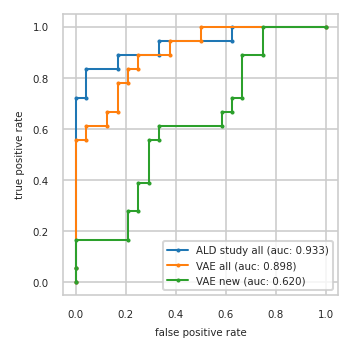

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.722   0.000 0.556   0.000 0.167
3          0.042 0.722   0.042 0.556   0.208 0.167
4          0.042 0.833   0.042 0.611   0.208 0.278
5          0.167 0.833   0.125 0.611   0.250 0.278
6          0.167 0.889   0.125 0.667   0.250 0.389
7          0.333 0.889   0.167 0.667   0.292 0.389
8          0.333 0.944   0.167 0.778   0.292 0.556
9          0.625 0.944   0.208 0.778   0.333 0.556
10         0.625 1.000   0.208 0.833   0.333 0.611
11         1.000 1.000   0.250 0.833   0.583 0.611
12           NaN   NaN   0.250 0.889   0.583 0.667
13           NaN   NaN   0.375 0.889   0.625 0.667
14           NaN   NaN   0.375 0.944   0.625 0.722
15           NaN   NaN   0.500 0.944   0.667 0.722
16           NaN   NaN   0.500 1.000   0.667 0.889
17           NaN   NaN   1.000 1.000   0.750 0.889
18           NaN   NaN     NaN   NaN   0.750 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02741,P48163,H0Y7T8;P49418;P49418-2
2,Q13433,A6NNI4;G8JLH6;P21926,Q9NUQ9
3,P61981,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P09960;P09960-4,P61981,Q96GD0
5,P04075,C9JF17;P05090,P31321
6,P14174,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,P14174,J3KSJ8;Q9UD71;Q9UD71-2
8,P08294,Q14894,Q9H741


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


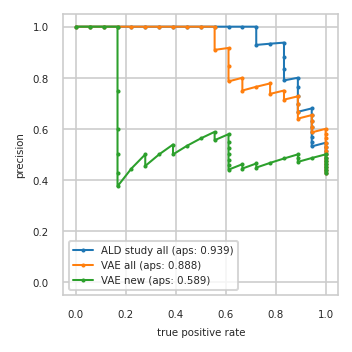

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.630 0.944     0.444 0.667
16         0.654 0.944     0.654 0.944     0.462 0.667
17         0.680 0.944     0.640 0.889     0.440 0.611
18         0.667 0.889     0.667 0.889     0.458 0.611
19         0.696 0.889     0.696 0.889     0.478 0.611
20         0.727 0.889     0.727 0.889     0.500 0.611
21         0.762 0.889     0.714 0.833     0.524 0.611
22         0.800 0.889     0.750 0.833     0.550 0.611
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.833 0.833     0.778 0.778     0.556 0.556
25         0.882 0.833     0.765 0.722     0.588 0.556
26         0.938 0.833     0.750 0.667     0.562 0.500
27         0.933 0.778     0.800 0.667     0.533 0.444
28         0.929 0.722     0.786 0.611     0.500 0.389
29         1.000 0.722     0.846 0.611     0.538 0.389
30         1.000 0.667     0.917 0.611     0.500 0.333
31         1.000 0.611     0.909 0.556     0.455 0.278
32         1.000 0.556     1.000 0.556     0.500 0.278
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.375 0.167
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


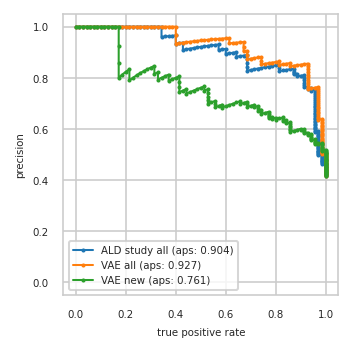

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


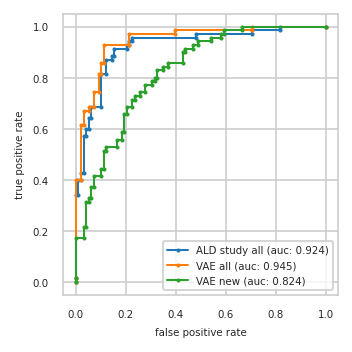

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}